In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import torch

from dataset import camels2D_256_LH_CV_z_dataset
from utils import utils
from model import networks

import importlib
importlib.reload(networks)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/n/home12/cfpark00/venv1/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: rch is an invalid version and will not be supported in a future release
  warnings.warn(
/n/home12/cfpark00/venv1/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: rch is an invalid version and will not be supported in a future release
  warnings.warn(


In [7]:
h5fn_inpaint="./data/inpainting/LH_2D_256.h5"
with h5py.File(h5fn_inpaint, "r") as h5:
    fields_Z =np.array(h5["Z"])
fields_Z.shape

(15000, 256, 256)

In [8]:
np.isnan(fields_Z).sum()

0

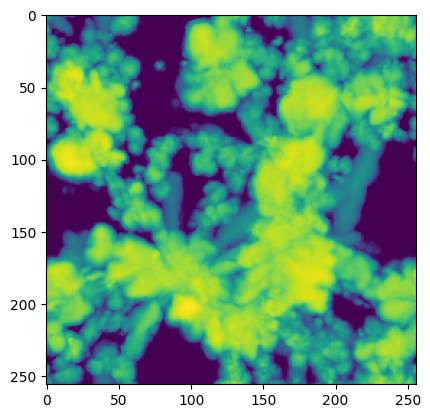

In [6]:
plt.imshow(fields_Z[0,:,:])

In [30]:
import glob
import os
import tqdm
ckpt_dir="./data/comet_logs/Mstar2Mcdm-2D-inpaint/e57eb68440d348b381d9c875aba779c9/checkpoints/"
ckpt_paths=glob.glob(os.path.join(ckpt_dir,"*.ckpt"))
def get_steps(ckpt_path):
    return int(os.path.split(ckpt_path)[1].split("=")[-1].split(".")[0])
ckpt_paths.sort(key=get_steps)
len(ckpt_paths)

91

In [31]:
bs=[]
ws=[]
for ckpt_path in tqdm.tqdm(ckpt_paths):
    ckpt=torch.load(ckpt_path)
    b=ckpt["state_dict"]["model.gamma.b"].item()
    w=ckpt["state_dict"]["model.gamma.w"].item()
    bs.append(b)
    ws.append(w)

100%|██████████| 91/91 [01:36<00:00,  1.06s/it]


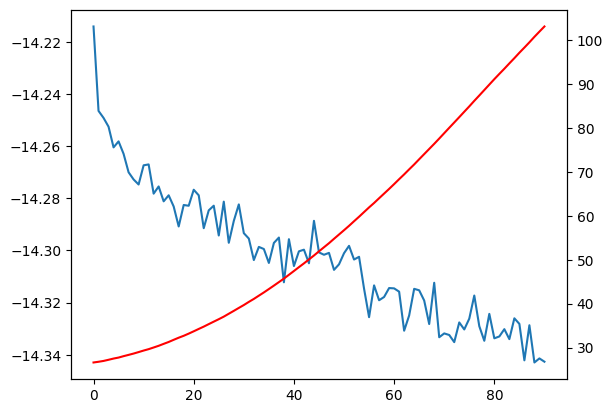

In [33]:
plt.plot(bs)
plt.twinx()
plt.plot(ws,c="r")

In [34]:
bs[-1]

-14.342687606811523

In [45]:
bs[0]

-14.214069366455078

In [50]:
i=-1
b_tr=torch.tensor(bs[i])
bs[i],torch.sqrt(torch.sigmoid(-b_tr)).item(),b_tr.dtype

(-14.342687606811523, 0.9999997019767761, torch.float32)

In [51]:
b_test=-15.
b_tr=torch.tensor(b_test)
b_test,torch.sqrt(torch.sigmoid(-b_tr)).item(),b_tr.dtype

(-15.0, 0.9999998211860657, torch.float32)

In [52]:
12/torch.sqrt(torch.sigmoid(-b_tr))

tensor(12.0000)

In [35]:
cropsize=32

gamma_min=-13.3
gamma_max= 5.0
embedding_dim= 32
norm_groups= 4
n_blocks= 4
n_conditioning_values=6

net=networks.UNet3D4VDM(
    input_channels= 1,
    conditioning_channels = 1,
    conditioning_values = 6,
    cond_value_mode="comb",#"comb" or "sep"
    embedding_dim=32,
    emb_mult_t=4,
    n_blocks = 4,  
    norm_groups= 8,

    dropout_prob= 0.1,
    gamma_min = -13.3,
    gamma_max = 5.0,
)

In [36]:
net=net.to(device)

In [38]:
z=torch.randn(1,1,cropsize,cropsize,cropsize).to(device)
g_t=torch.randn(1).to(device)
conditioning=torch.randn(1,1,cropsize,cropsize,cropsize).to(device)
conditioning_values=torch.randn(1,6).to(device)
res=net(z,g_t,conditioning=conditioning,conditioning_values=conditioning_values)
res.shape

torch.Size([1, 1, 32, 32, 32])

In [17]:
def a(a,b,c=0,d=0,**kwargs):
    print(a,b,c,d,kwargs)
def b(*args,**kwargs):
    a(*args,d=1,**kwargs)

In [20]:
b(1,2,3,5,condd=8)

TypeError: a() got multiple values for argument 'd'

In [5]:
dm = camels2D_256_LH_CV_z_dataset.get_dataset_2D_256_LH_CV_z(
        z_star="0.0",
        z_cdm="0.0",
        num_workers=4,
        cropsize=256,
        batch_size=2,
        stage="fit",
        return_params=True,
    )

In [6]:
for c,x,p in dm.train_dataloader():
    break

In [8]:
p

tensor([[0.1782, 0.7138, 0.6625, 2.9773, 0.7285, 0.6475],
        [0.1894, 0.8726, 2.7095, 3.2355, 0.7584, 0.5559]])

In [3]:
with h5py.File("/n/holystore01/LABS/itc_lab/Lab/Camels/2d_from_3d/CV256.h5","r") as h5:
    mass_cdm = np.array(h5["mcdm_z=0.0"][:,:1,:1])
    print(mass_cdm.shape)
    print(h5["params"])

(405, 1, 1)
<HDF5 dataset "params": shape (27, 6), type "<f8">


In [8]:
np.repeat(np.array([[1,2],[3,4]]),axis=0,repeats=2)

array([[1, 2],
       [1, 2],
       [3, 4],
       [3, 4]])

In [6]:
net=networks.UNet3D4VDM(
        input_channels = 1,
        conditioning_channels = 1,
        embedding_dim=8,
        n_blocks = 4,  
        norm_groups = 2,

        dropout_prob = 0.1,
        gamma_min = -13.3,
        gamma_max = 5.0,
    )

In [9]:
with torch.no_grad():
    res=net(torch.randn(1,1,32,32,32),torch.tensor([1.]),torch.randn(1,1,32,32,32))

In [10]:
res.shape

torch.Size([1, 1, 32, 32, 32])

In [2]:
dm=camels2D_256_LH_CV_z_dataset.get_dataset_2D_256_LH_CV_z(stage="fit")

In [3]:
for x,y in dm.train_dataloader():
    print(x.shape)
    print(y.shape)
    break

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


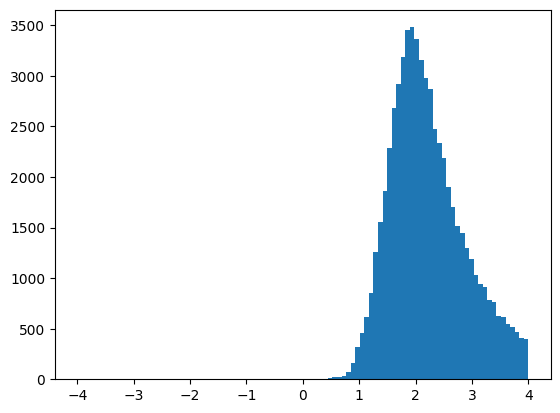

In [5]:
plt.hist(utils.to_np(y).flatten(),bins=np.linspace(-4,4,100))
None